In [36]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.interpolate import UnivariateSpline
from math import floor, ceil

In [80]:
CONFIG = {
    'total_points' : 300,
    'frequency' : 10,
    'default_norm_len' : 4,
    'height_max': 10
}

In [81]:
total_points = CONFIG['total_points']
freq = CONFIG['frequency']
norm_len = CONFIG['default_norm_len']
height_max = CONFIG['height_max']

In [30]:
def gen_normal_distribution(x, mu, sigma):
    """
    生成正态分布数据
    """
    values = np.exp(-(x - mu)**2 / (2 * sigma**2)) / (sigma * np.sqrt(2 * np.pi))
    return values

In [31]:
def sigma_random_list(freq):
    """
    sigma的随机列表
    """
    return freq * np.concatenate((np.arange(0.1, 4, 0.5), np.arange(
        0.1, 1, 0.2), np.arange(1, 2, 0.1), np.arange(1, 3, 0.1)))

In [109]:
def gen_one_sample(total_points, freq, overlap_rate, peak_num):
    """
    生成单个样本
    
    params:
        total_points:                 int，采样点数量
        freq:                         int，采样频率
        overlap_rate:                 float，重叠率，0-1
        peak_num:                     int，生成峰数量上限
        
    return:
        sample:                       1D array, 峰重叠数据
        y:                            1D array, 训练标签
                                            [start1, top1, end1, height1, start2, top2, end2, height2, ...]
                        
    """
    sample = np.zeros(total_points)
    y = []
    
    overlap_dis = (1-overlap_rate) * norm_len
    overlap_tag = np.ones(total_points)
    
    all_loc = np.arange(total_points, dtype=int)
    
    sigma_list = sigma_random_list(freq)
    
    height_list = np.arange(height_max, 0.1)
    
    for i in range(peak_num):
        left_loc = all_loc[overlap_tag == 1]
        
        # check left location
        if left_loc.shape[0] == 0:
            break
        
        # random mu and sigma
        mu = random.choice(left_loc)
        sigma = random.choice(sigma_list)
        
        start, end = math.floor(mu-norm_len*sigma), ceil(mu+norm_len*sigma)
        start_i, end_i = max(0, start), min(total_points, end)

        tag_start, tag_end = floor(mu-overlap_dis*sigma), ceil(mu+overlap_dis*sigma)
        tag_start, tag_end = max(0, tag_start), min(total_points, tag_end)
        overlap_tag[tag_start:tag_end] = 0
        
        x= np.arange(start_i,end_i) 
        values = gen_normal_distribution(x, mu, sigma)
        y.append([start, mu, end, values.max()])
        
        sample[start_i:end_i] += values
        
        
    return sample, np.array(y).reshape(-1)

In [135]:
def plot_sample(total_points, sample, y):
    
    time_series = np.arange(total_points)
    
    plt.figure(dpi=400)
    plt.plot(time_series, sample, label='raw')
    
    for [start, top, end, height] in y.reshape((-1, 4)):
        x= np.arange(start,end+1)
        sigma = round((end-start) / norm_len / 2, 2)
        values = gen_normal_distribution(x, top, sigma)
        values = values * height / values.max()
        
        plt.plot(x, values, color='red', linestyle='--', linewidth=0.5)
        plt.vlines(top, -0.03, height,color='grey', linestyle='--', linewidth=0.5)
        
    y_spl = UnivariateSpline(time_series,sample,s=0,k=4)
    sample_2d = y_spl.derivative(n=2)
    plt.plot(time_series, sample_2d(time_series)*10, color='black', linewidth=0.5, label='2d')
    
    plt.plot(time_series, np.zeros(total_points), color='blue', linewidth=0.1, label='0')
    
    plt.legend()
    plt.show()

In [139]:
sample, y = gen_one_sample(total_points, 5, 0.6, 10)

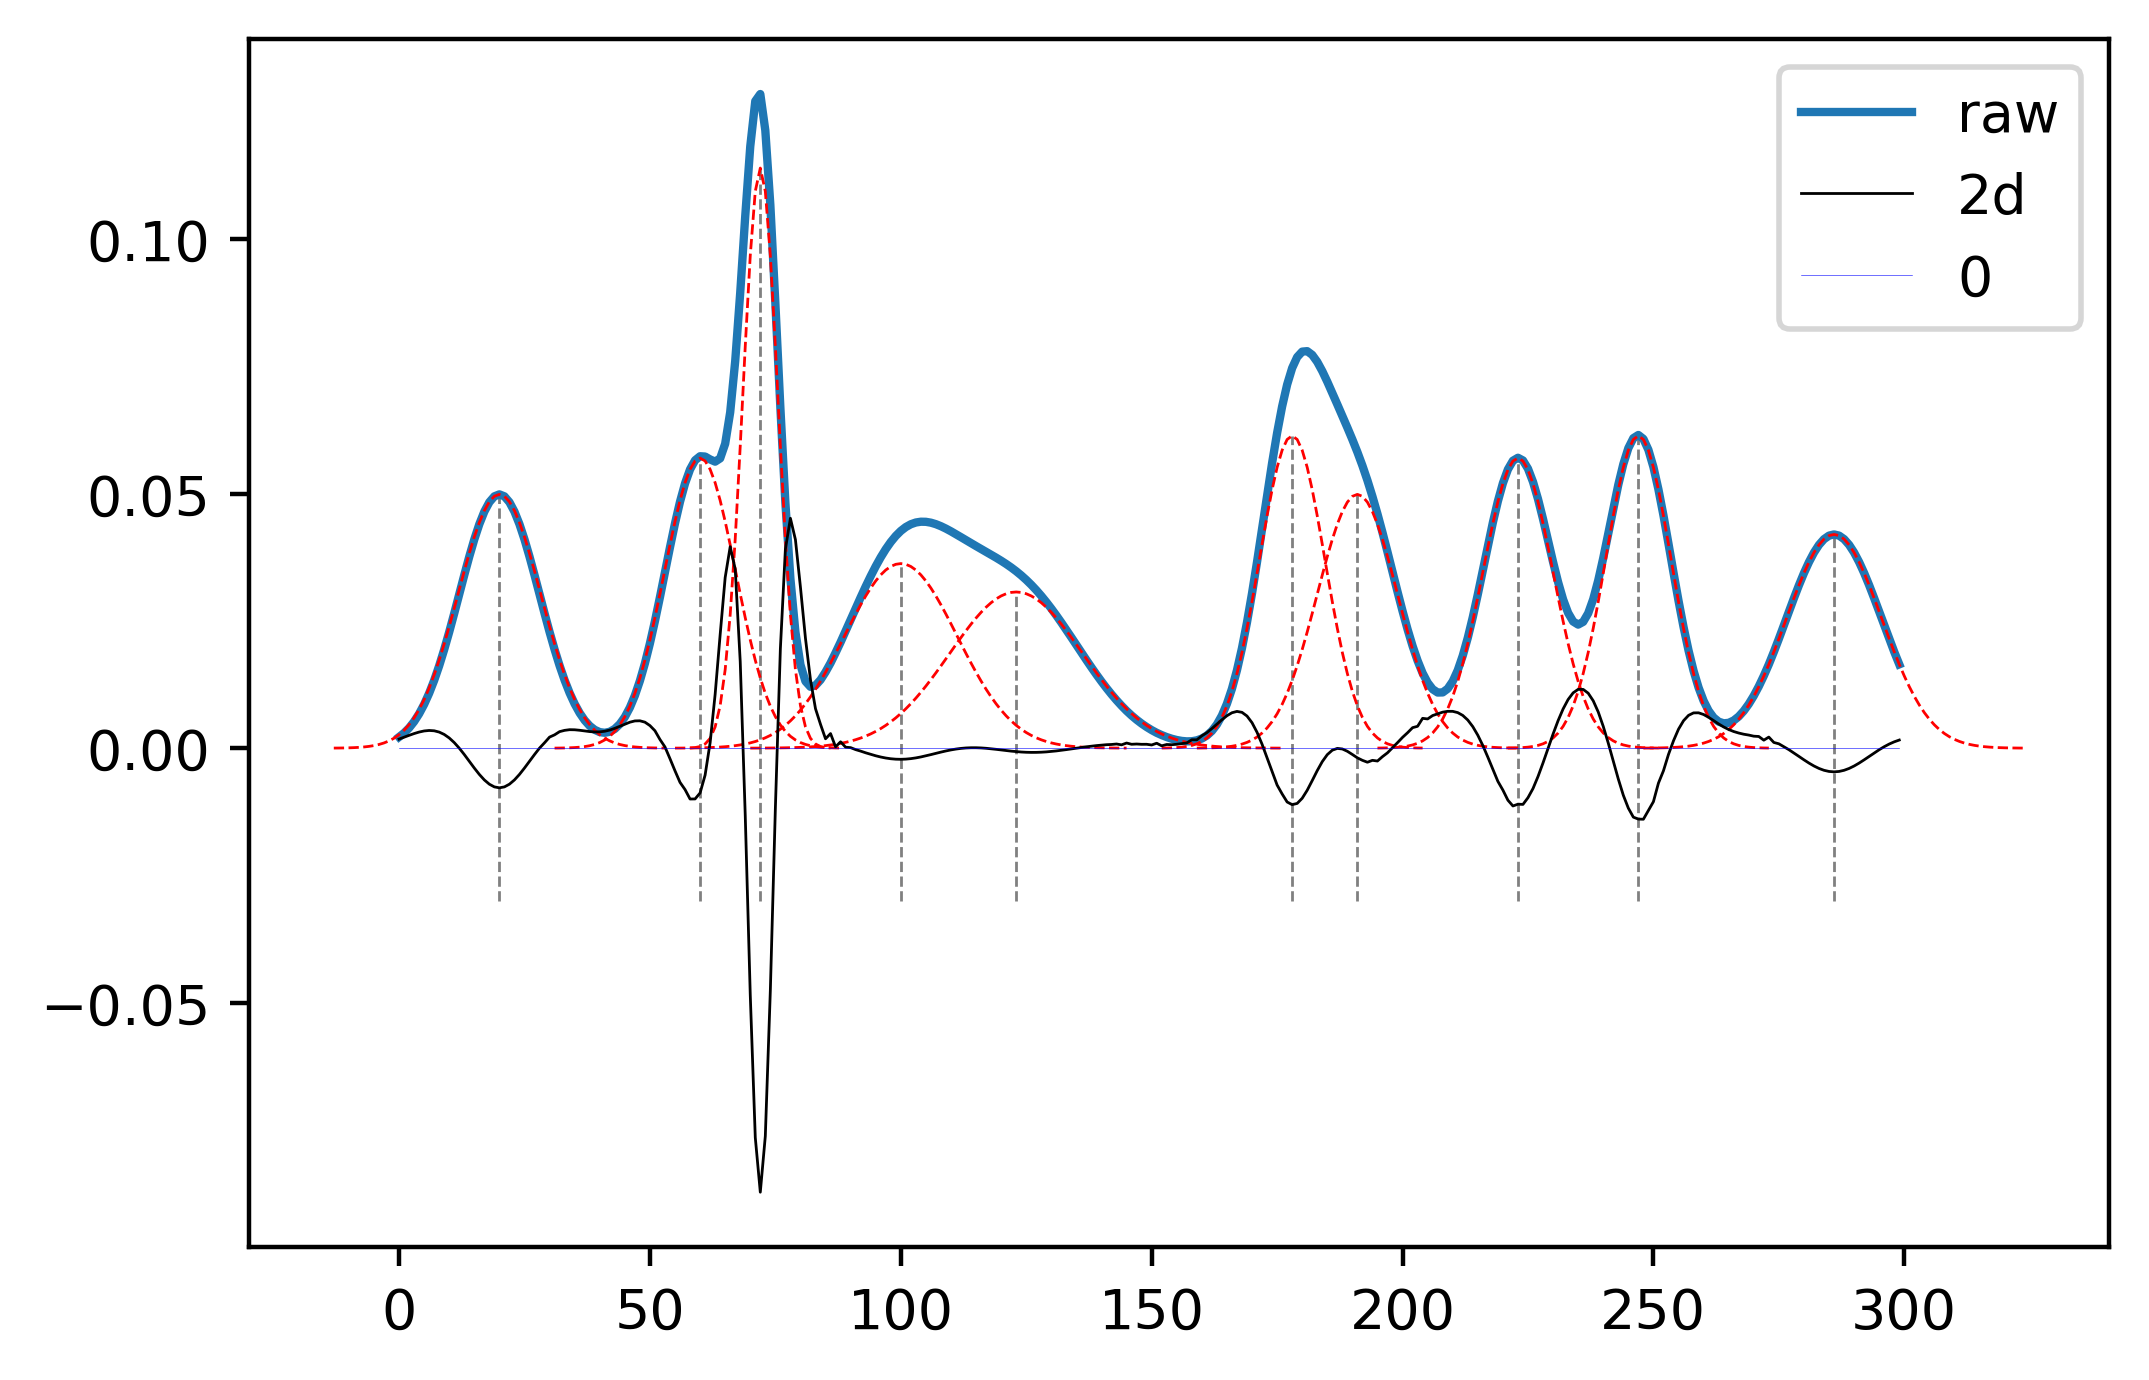

In [140]:


plot_sample(total_points, sample, y)